In [3]:
!pip install -q kaggle

# Create a directory and move the kaggle.json file to it to ensure the correct permissions
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d dheerajperumandla/drowsiness-dataset


drowsiness-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip -q drowsiness-dataset.zip -d drowsiness_dataset


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [7]:
# Define input image size
input_shape = (224, 224, 3)

# Define batch size
batch_size = 32

# Create data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/drowsiness_dataset/train',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drowsiness_dataset/train',
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 2321 images belonging to 4 classes.
Found 579 images belonging to 4 classes.


In [8]:
# Load pre-trained GoogLeNet model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Assuming 4 classes: Open, Closed, Yawn, NoYawn

# Create the new model
model = Model(inputs=base_model.input, outputs=output)


87910968/87910968 [==============================] - 1s 0us/step


In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=epochs)


Epoch 1/10
72/72 [==============================] - 1160s 16s/step - loss: 0.2180 - accuracy: 0.9214 - val_loss: 0.3553 - val_accuracy: 0.9427
Epoch 2/10
72/72 [==============================] - 1133s 16s/step - loss: 0.0255 - accuracy: 0.9934 - val_loss: 0.1020 - val_accuracy: 0.9653
Epoch 3/10
72/72 [==============================] - 1134s 16s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0751 - val_accuracy: 0.9774
Epoch 4/10
72/72 [==============================] - 1108s 15s/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.1707 - val_accuracy: 0.9410
Epoch 5/10
72/72 [==============================] - 1124s 16s/step - loss: 0.0154 - accuracy: 0.9978 - val_loss: 0.0853 - val_accuracy: 0.9740
Epoch 6/10
72/72 [==============================] - 1131s 16s/step - loss: 0.0116 - accuracy: 0.9978 - val_loss: 0.0582 - val_accuracy: 0.9844
Epoch 7/10
72/72 [==============================] - 1127s 16s/step - loss: 0.0055 - accuracy: 0.9978 - val_loss: 0.1352 - val_accuracy: 0.9601

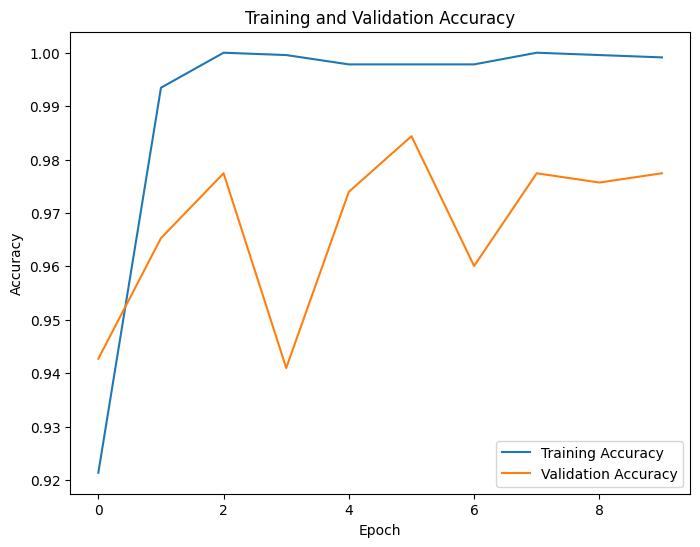

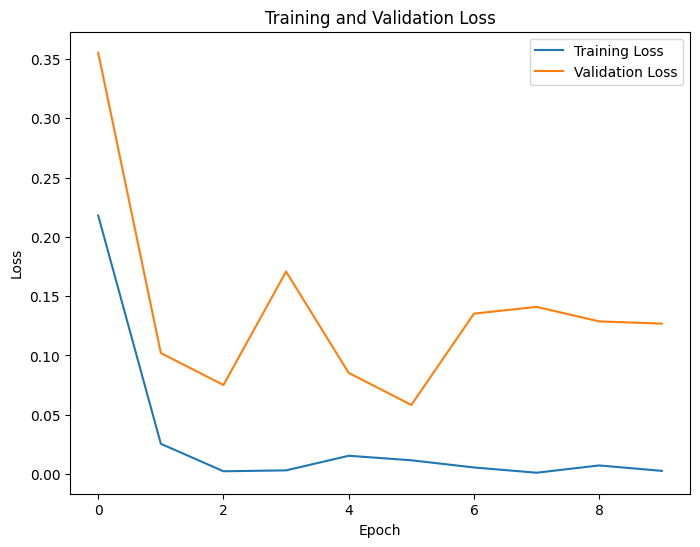

19/19 [==============================] - 68s 3s/step


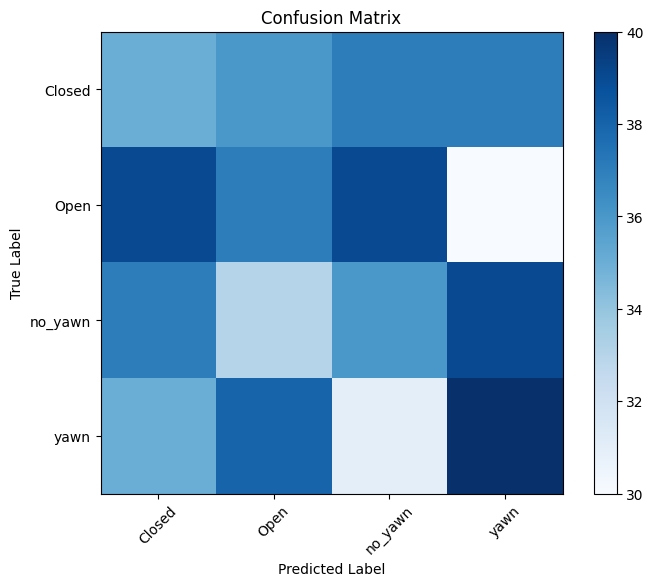

              precision    recall  f1-score   support

      Closed       0.24      0.24      0.24       145
        Open       0.26      0.26      0.26       145
     no_yawn       0.25      0.25      0.25       145
        yawn       0.27      0.28      0.28       144

    accuracy                           0.26       579
   macro avg       0.26      0.26      0.26       579
weighted avg       0.26      0.26      0.26       579



In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Plot the Training and Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Generate Predictions for the Validation Set
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the True Labels for the Validation Set
y_true = validation_generator.classes

# Create the Confusion Matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(train_generator.class_indices))
plt.xticks(tick_marks, train_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, train_generator.class_indices.keys())
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print Classification Report
class_labels = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


1/1 [==============================] - 0s 295ms/step


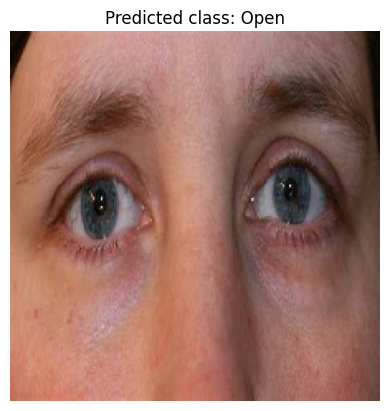

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the new image
new_image_path = '/content/OIP.jpeg'
img = image.load_img(new_image_path, target_size=(input_shape[0], input_shape[1]))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image, similar to how we did for training data

# Make the prediction
prediction = model.predict(x)
class_labels = train_generator.class_indices  # Get the mapping of class labels to their numeric values

# Convert prediction to human-readable class label
predicted_class_label = list(class_labels.keys())[np.argmax(prediction)]

# Display the image and predicted class label
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 1s 746ms/step


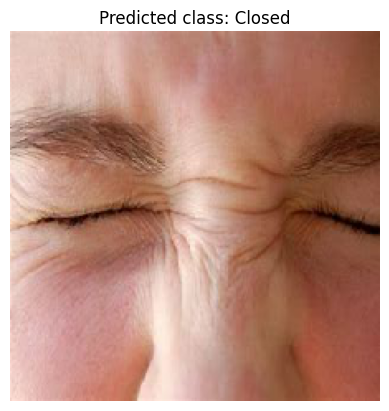

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the new image
new_image_path = '/content/CE.jpeg'
img = image.load_img(new_image_path, target_size=(input_shape[0], input_shape[1]))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image, similar to how we did for training data

# Make the prediction
prediction = model.predict(x)
class_labels = train_generator.class_indices  # Get the mapping of class labels to their numeric values

# Convert prediction to human-readable class label
predicted_class_label = list(class_labels.keys())[np.argmax(prediction)]

# Display the image and predicted class label
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 159ms/step


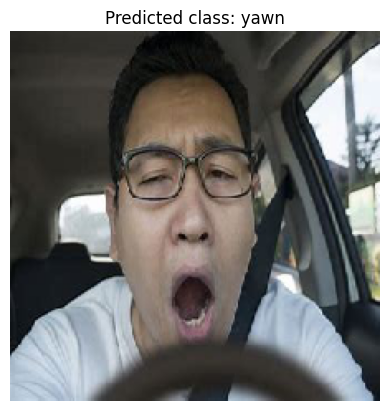

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the new image
new_image_path = '/content/YD.jpeg'
img = image.load_img(new_image_path, target_size=(input_shape[0], input_shape[1]))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image, similar to how we did for training data

# Make the prediction
prediction = model.predict(x)
class_labels = train_generator.class_indices  # Get the mapping of class labels to their numeric values

# Convert prediction to human-readable class label
predicted_class_label = list(class_labels.keys())[np.argmax(prediction)]

# Display the image and predicted class label
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class_label}")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 137ms/step


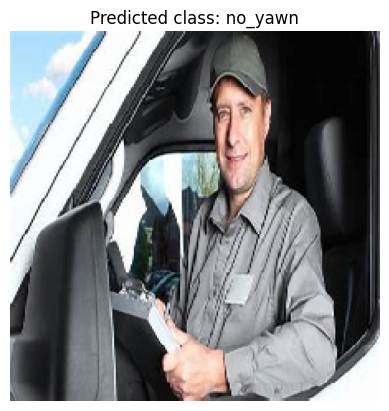

In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the new image
new_image_path = '/content/NYD.jpeg'
img = image.load_img(new_image_path, target_size=(input_shape[0], input_shape[1]))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalize the image, similar to how we did for training data

# Make the prediction
prediction = model.predict(x)
class_labels = train_generator.class_indices  # Get the mapping of class labels to their numeric values

# Convert prediction to human-readable class label
predicted_class_label = list(class_labels.keys())[np.argmax(prediction)]

# Display the image and predicted class label
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class_label}")
plt.axis('off')
plt.show()
